<a href="https://colab.research.google.com/github/rahulrajpr/TensorFlowDeveloperCertifcateTraining/blob/TransferLearning/ComputerVision_with_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as nu
import matplotlib.pyplot as plt
import matplotlib.image as mpim
import zipfile
import warnings
warnings.filterwarnings('ignore')
import os

import tensorflow as tf

Get the files downloaded

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zipref = zipfile.ZipFile('10_food_classes_10_percent.zip')

zipref.extractall()

zipref.close()

--2023-02-12 13:40:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   225MB/s    in 0.7s    

2023-02-12 13:40:01 (225 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



Navigate through the directory

In [ ]:
for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):

  print('There are {0} directories and {1} images inside'.format(len(dirname),len(filename)))

There are 2 directories and 0 images inside
There are 10 directories and 0 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 0 directories and 75 images inside
There are 10 directories and 0 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
There are 0 directories and 250 images inside
Th

Note : There are 75 images in each train classes and 250 images in test folders

## Load the images using the Image Data Generator

In [ ]:
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_data_gen = ImageDataGenerator(rescale = 1/255.)
test_data_gen = ImageDataGenerator(rescale = 1/255.)

In [ ]:
print('Train Data')
train_data = train_data_gen.flow_from_directory(directory = train_dir,
                                                target_size = IMG_SIZE,
                                                batch_size = BATCH_SIZE,
                                                class_mode = 'categorical')

print('Test Data')

test_data = test_data_gen.flow_from_directory(directory = test_dir,
                                              target_size = IMG_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical')

Train Data
Found 750 images belonging to 10 classes.
Test Data
Found 2500 images belonging to 10 classes.


In [ ]:
num_classes = train_data.num_classes
num_classes

10

### Introducing Callbacks

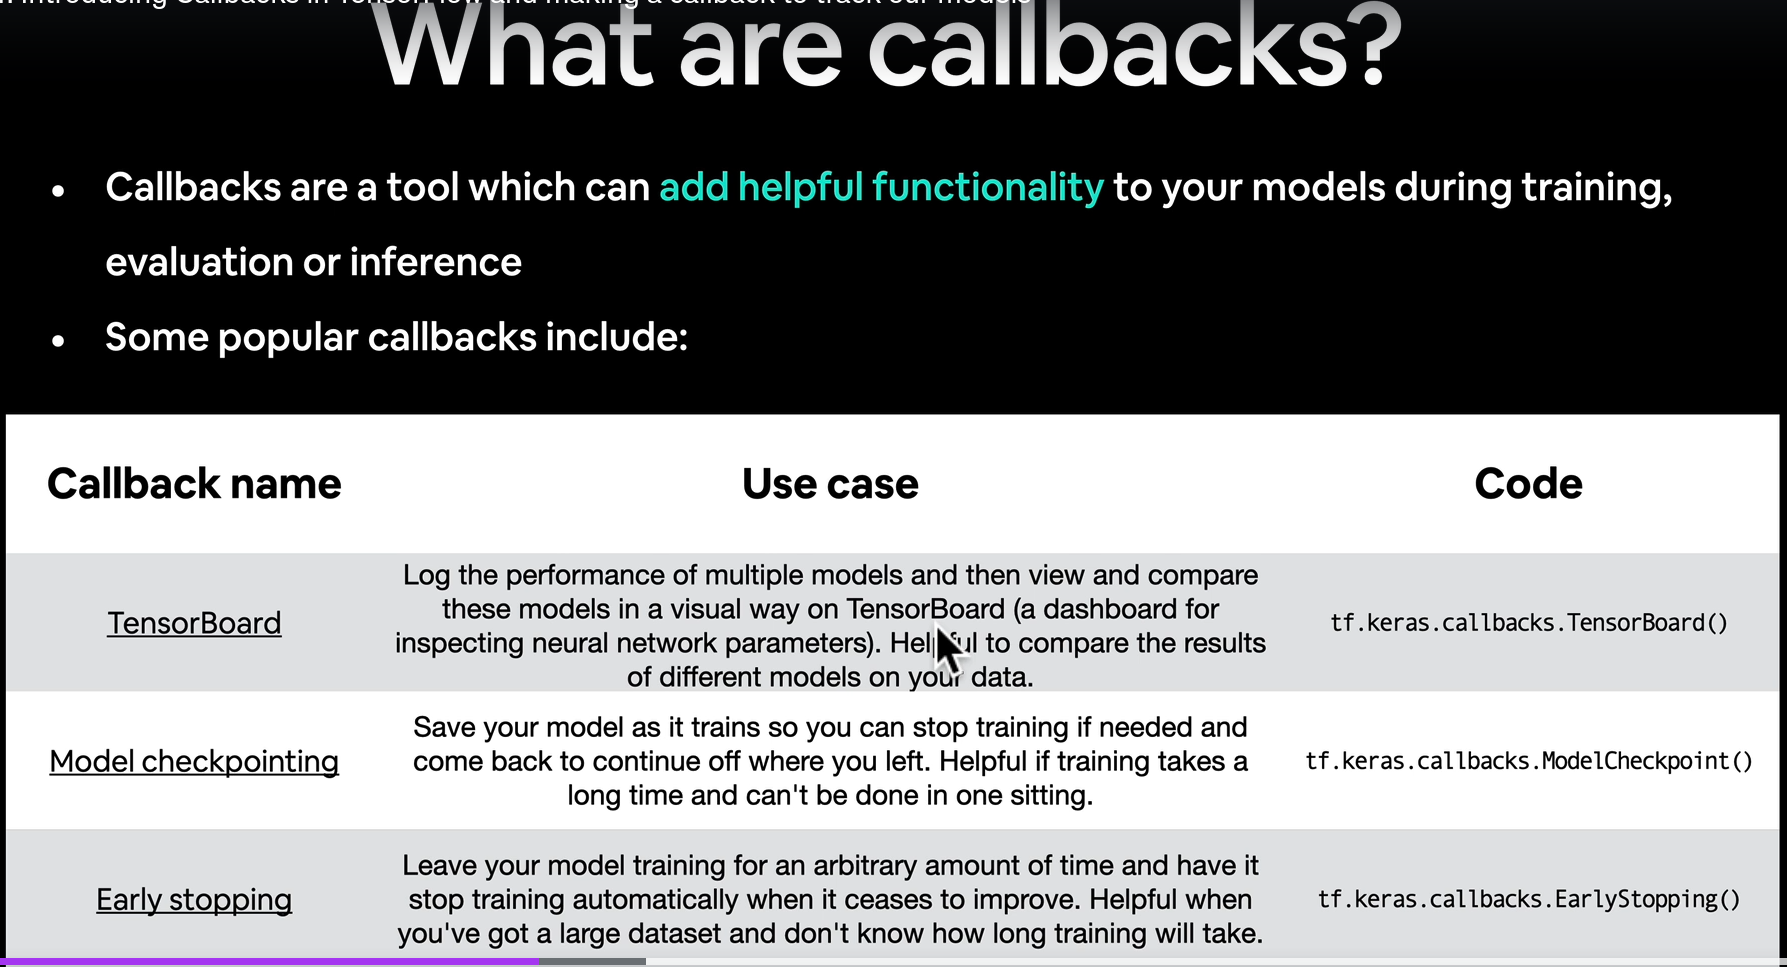

Create a function for TensorBoard Callback

In [ ]:
import datetime

def create_tensorborad_callback(dir_name, experiment_name):

  timestamp = datetime.datetime.now().strftime('%Y%m%d -%H%M%S')

  log_dir = dir_name+'/'+experiment_name+'/'+timestamp

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

  print('Saving the tensorboard log file @ : ',log_dir)

  return tensorboard_callback

Introducing tfhub.dev


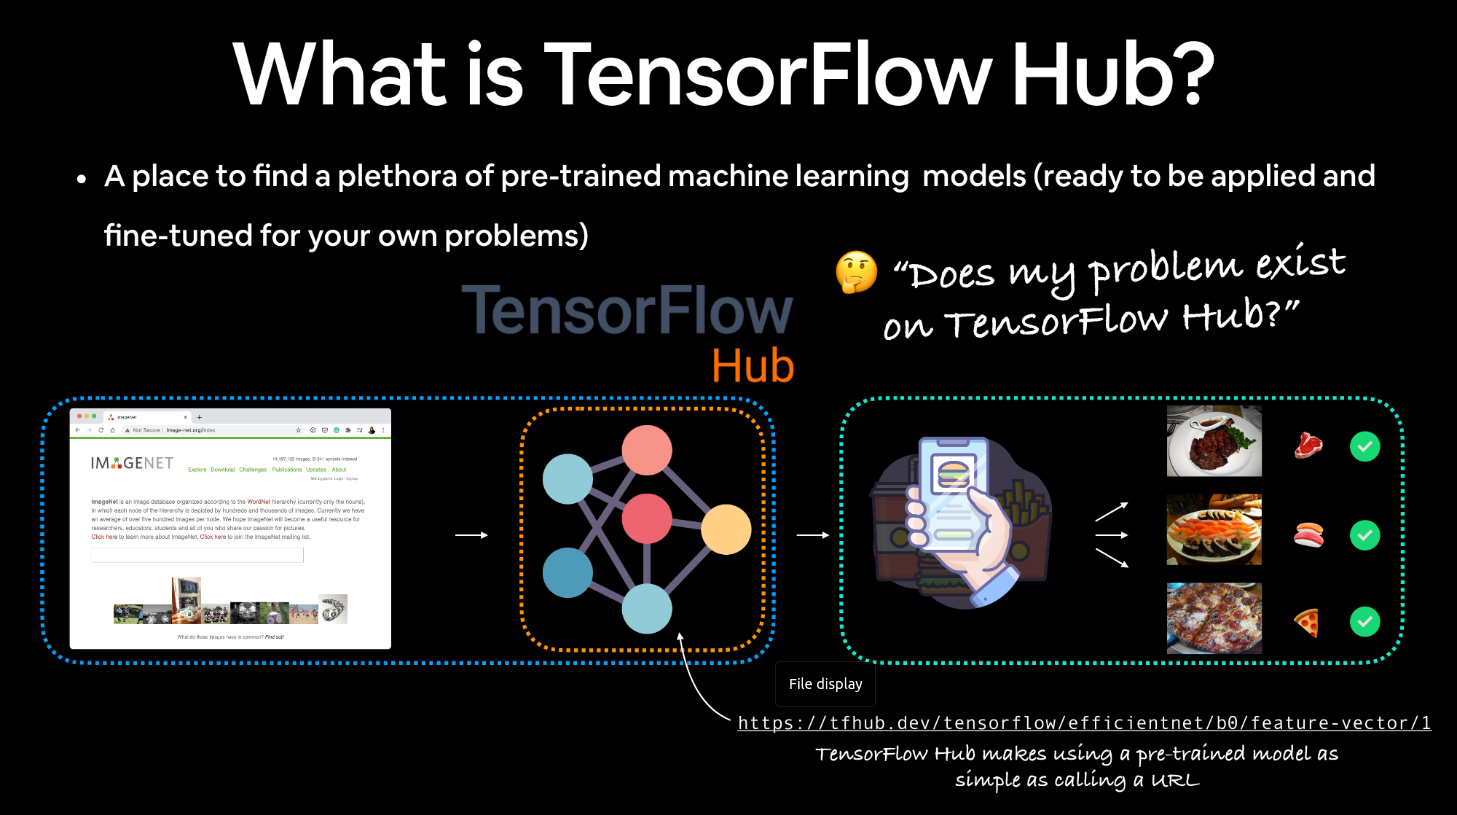

finding some of the pre-trainined model from tensoflow hub which are related to image feature extraction

In [ ]:
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5' # one od the best feature extraction model

efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1' # one od the best feature extraction model

creating a function for model building

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# function to build the model

def create_model(feat_ext_url, num_classes = num_classes):

  feature_extraction_layer = hub.KerasLayer(handle = feat_ext_url,
                                            trainable = False,
                                            input_shape = IMG_SIZE+(3,),
                                            name = 'feature_layer') # from tfhub url

  model = Sequential([ 
      feature_extraction_layer,
      Dense(units = num_classes, activation = 'softmax')])
  
  return model

create our first model using the resnet features extraction

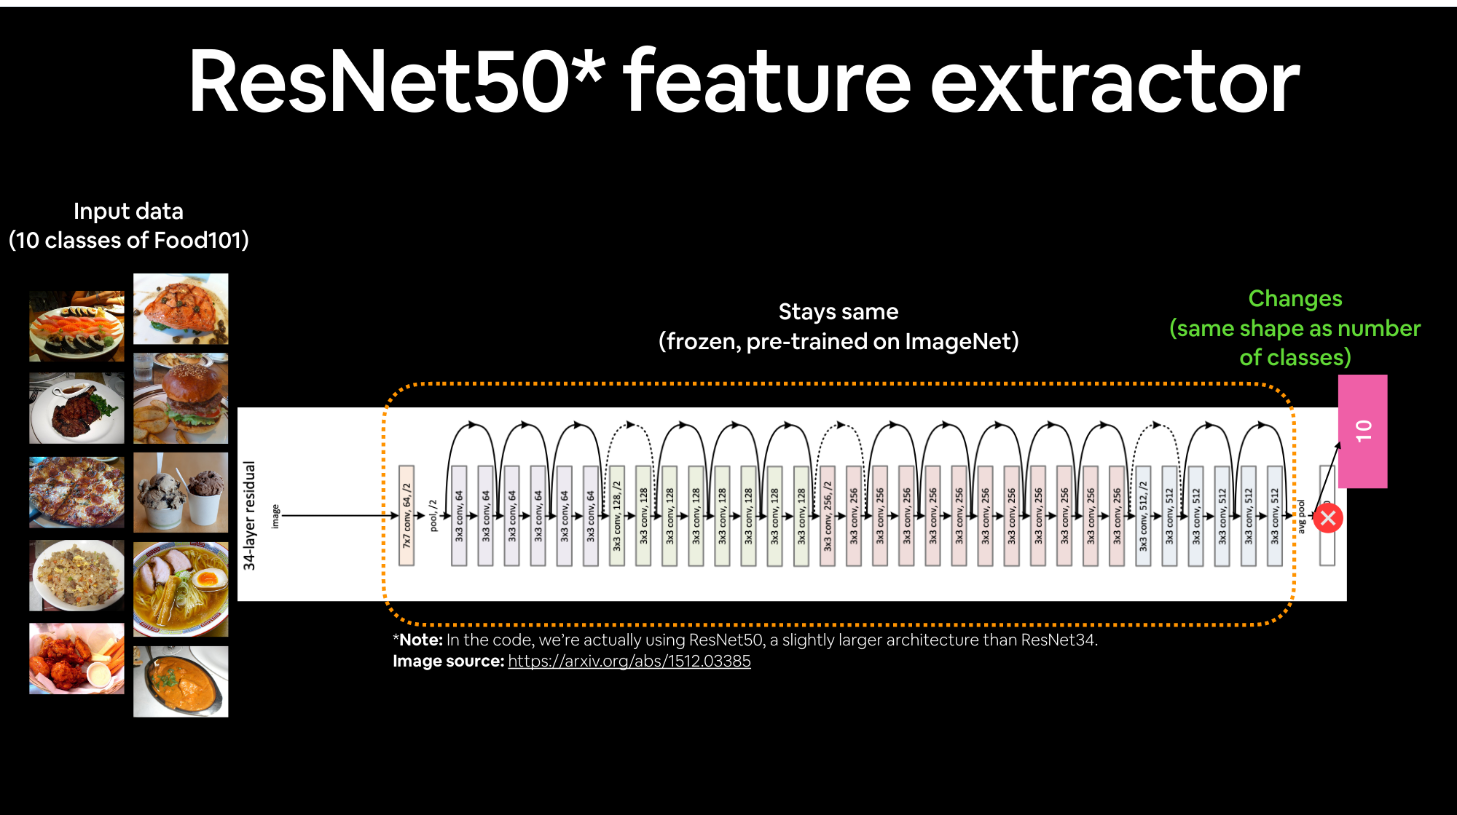

In [ ]:
model_resnet = create_model(feat_ext_url= resnet_url, num_classes = num_classes)
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_layer (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# lets compile and fit the model

model_resnet.compile(loss = 'categorical_crossentropy',
                     optimizer = Adam(),
                     metrics = ['accuracy'])

history_resnet = model_resnet.fit(train_data,
                                  epochs = 5,
                                  steps_per_epoch = len(train_data),
                                  validation_data = test_data,
                                  validation_steps = len(test_data),
                                  callbacks = [create_tensorborad_callback(dir_name = 'tensorflow_hub', experiment_name = 'resnet50v2')])

Saving the tensorboard log file @ :  tensorflow_hub/resnet50v2/20230212 -134005
Epoch 1/5
24/24 [==============================] - 20s 707ms/step - loss: 2.0354 - accuracy: 0.3533 - val_loss: 1.2517 - val_accuracy: 0.6076
Epoch 2/5
24/24 [==============================] - 16s 695ms/step - loss: 0.9343 - accuracy: 0.7240 - val_loss: 0.9008 - val_accuracy: 0.7144
Epoch 3/5
24/24 [==============================] - 16s 678ms/step - loss: 0.6526 - accuracy: 0.8213 - val_loss: 0.7472 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 16s 685ms/step - loss: 0.4963 - accuracy: 0.8667 - val_loss: 0.7068 - val_accuracy: 0.7704
Epoch 5/5
24/24 [==============================] - 16s 675ms/step - loss: 0.3944 - accuracy: 0.9120 - val_loss: 0.6726 - val_accuracy: 0.7796


In [ ]:
# lets evauate the model

model_resnet.evaluate(test_data)

79/79 [==============================] - 13s 158ms/step - loss: 0.6726 - accuracy: 0.7796


[0.6725950837135315, 0.7796000242233276]

In [ ]:
# create a loss curve function

def eval_plot(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.figure(figsize = (18,6))
  plt.subplot(1,2,1)
  plt.plot(loss, label = 'loss')
  plt.plot(val_loss,label = 'validation loss')
  plt.xlabel('epochs')
  plt.title('loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(accuracy, label = 'accuracy')
  plt.plot(val_accuracy,label = 'validation accuracy')
  plt.xlabel('epochs')
  plt.title('accuracy')
  plt.legend()

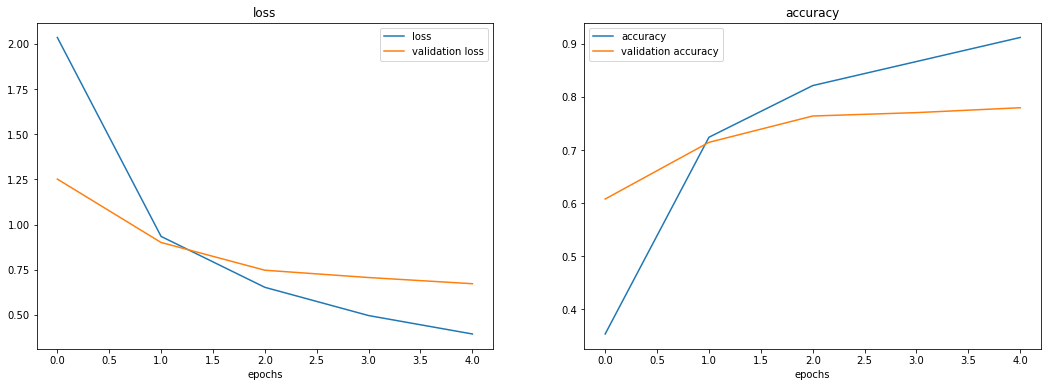

In [ ]:
eval_plot(history_resnet)

create our first model using the efficient features extraction

Details of Efficient Net : https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

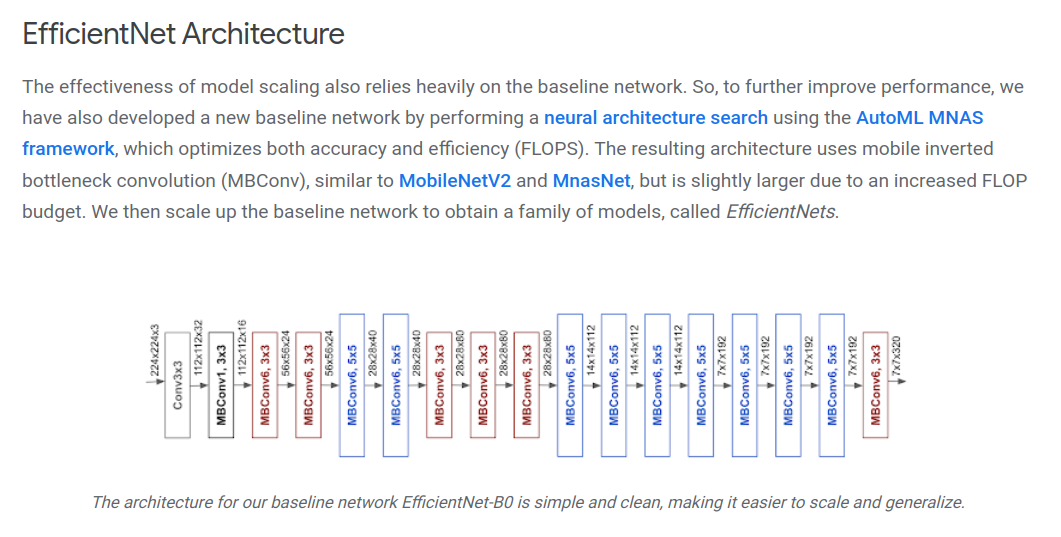

In [ ]:
model_efficientnet = create_model(feat_ext_url= efficientnet_url, num_classes = num_classes)
model_efficientnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_layer (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_3 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# lets compile and fit the model

model_efficientnet.compile(loss = 'categorical_crossentropy',
                           optimizer = Adam(),
                           metrics = ['accuracy'])

history_efficientnet = model_efficientnet.fit(train_data,
                                              epochs = 5,
                                              steps_per_epoch = len(train_data),
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorborad_callback(dir_name = 'tensorflow_hub', experiment_name='efficientnetb0')])


Saving the tensorboard log file @ :  tensorflow_hub/efficientnetb0/20230212 -134203
Epoch 1/5
24/24 [==============================] - 20s 704ms/step - loss: 1.8855 - accuracy: 0.4013 - val_loss: 1.3196 - val_accuracy: 0.7288
Epoch 2/5
24/24 [==============================] - 15s 641ms/step - loss: 1.0863 - accuracy: 0.7720 - val_loss: 0.8797 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 15s 639ms/step - loss: 0.7772 - accuracy: 0.8267 - val_loss: 0.7051 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 15s 659ms/step - loss: 0.6179 - accuracy: 0.8560 - val_loss: 0.6119 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 15s 646ms/step - loss: 0.5245 - accuracy: 0.8827 - val_loss: 0.5583 - val_accuracy: 0.8640


In [ ]:
model_efficientnet.evaluate(test_data)

79/79 [==============================] - 12s 150ms/step - loss: 0.5583 - accuracy: 0.8640


[0.5583178997039795, 0.8640000224113464]

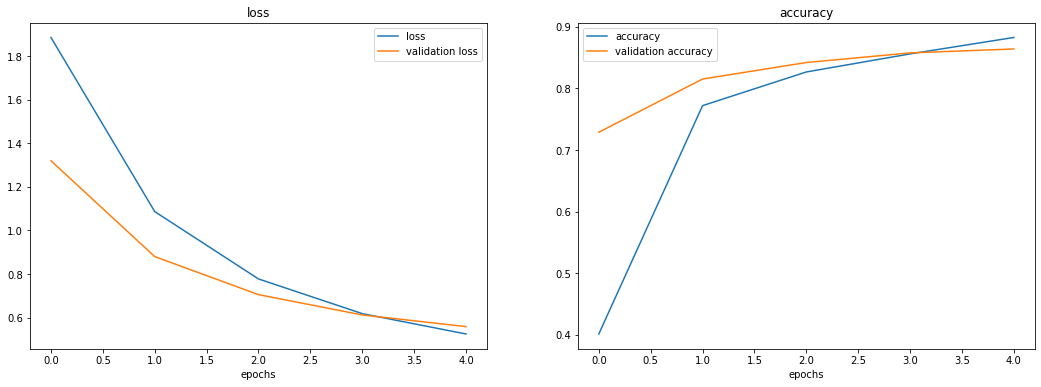

In [ ]:
eval_plot(history_efficientnet)

Efficient net performace comparison (General Comparison with other feature extractors in Tensorflow Hub)

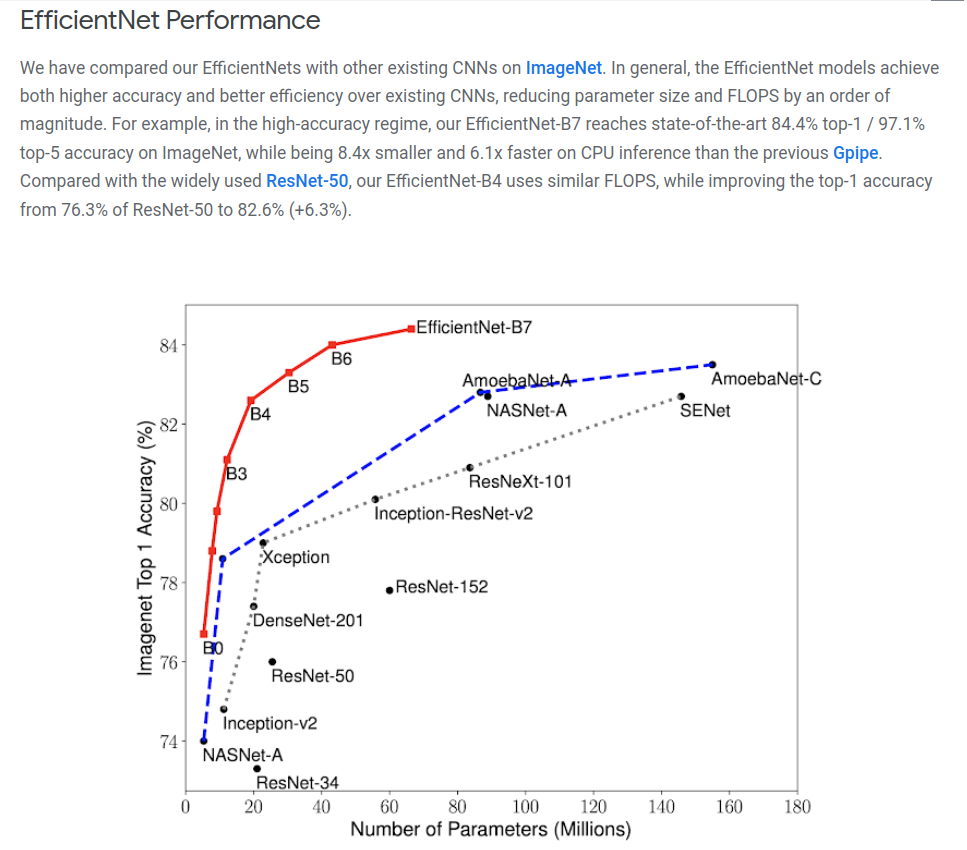

# Kinds of Transfer learming

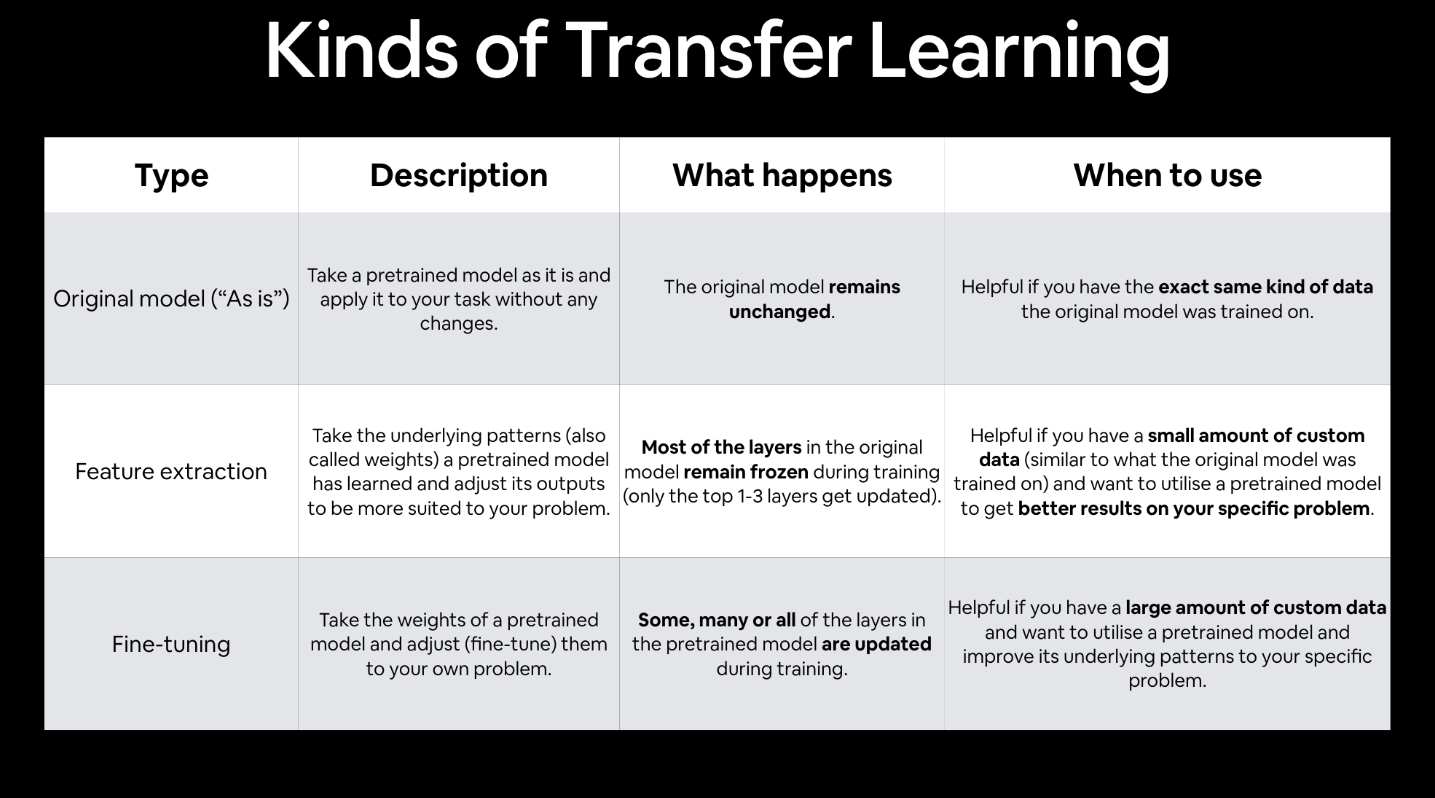

# Use Tensorboard to compare the model perfomance

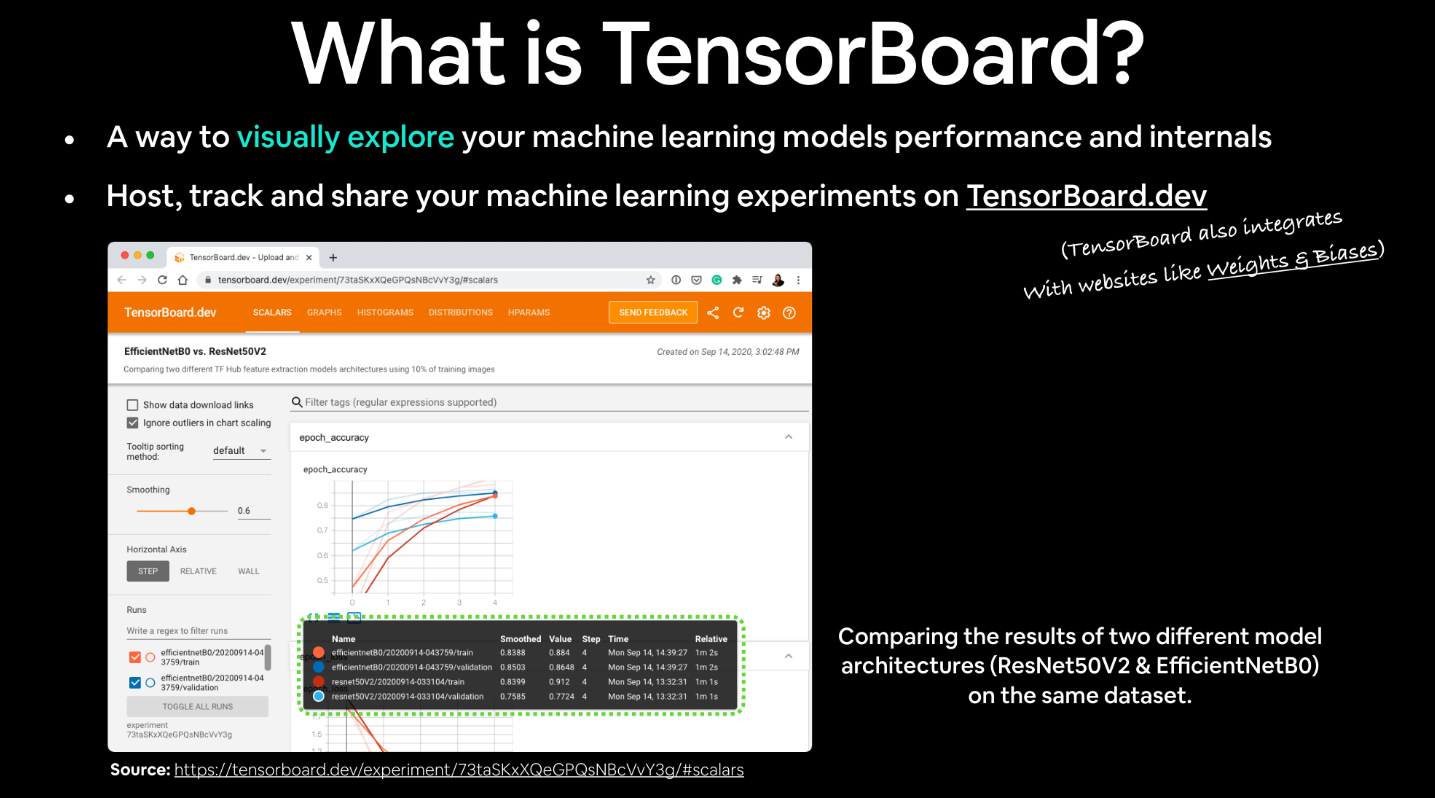